<a href="https://colab.research.google.com/github/CCS-ZCU/pribehy-dat/blob/master/scripts/1_uvod-do-jupyter-notebooku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Úvod a cíle kapitoly

V této kapitole si ukážeme základní principy práce s PDF soubory. Formát PDF zavedl v roce John Warnock, spoluzakladatel společnosti Adobe. Cílem bylo nalézt způsob, jak by se dokumenty z jakékoli aplikace daly jednoduše ukládat, posílat v elektronickém formátu a prohlížet a tisknout na jakémkoli počítači, aniž by došlo ke změně jejich podoby. 

PDF formát je nyní standardem pro digitalizaci knih či archivních dokumentů. V tomto kontextu rozlišujeme zejména mezi PDF soubory s rozpoznanou textovou vrstvou a bez ní. Digitalizovaný dokument bez rozpoznané textové vrstvi je víceméně pouze seznam obrázků. PDF s rozpoznanou textovou vrstvou má kromě vrstvy obrázků ještě vrstvu textových prvků, tzv. textových bloků. Textový blok je entita, která sestává z dat ohledně svého geometrického postavení na stránce (typicky dva body vymezující rohy obdelníku) a sestavy znaků textu. Jedná-li se o PDF dokument, který vznikl např. převodem `.docx` souboru, lze očekávat, že textový obsah bude bezchybný. Jedná-li se však o soubor, který vznikl digitalizací analogového dokumentu, často zde narazíme na určité nedostatky spjaté s technologií OCR. Této technologii se budeme věnovat v samostatné kapitole. 

V následujícím cvičení budeme PDF soubory zpracovávat pomocí Python knihovny `PyMuPDF`, která se do Python prostředí importuje pod přezdívkou `fitz`. 

Toto cvičení je postaveno na textech zpřístupněných na stránkách [scriptum.cz](https://scriptum.cz). Tato webová platforma zpřístupňuje českou exilovou a samizdatovou literaturu z období komunismu. Jedná se o projekt Sdružení občanů Exodus v Plzni a Třemošné, který funguje od roku 2007. Digitalizace textů je náplní práce lidí se zdravotním handicapem v rámci chráněné dílny. Jedná se o unikátní kolekci několika set titulů a více než 11 tisíc titulů. 

In [3]:
#!pip install PyMuPDF
import fitz
import requests
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
from bs4 import BeautifulSoup
import pandas as pd
import nltk

Pro ukázku si nyní do našeho Python prostředí načteme jedno číslo exilového časopisu *Studie*, revue Křesťanské akademie.  

In [2]:
url = "https://scriptum.cz/soubory/scriptum/%5Bnode%5D/studie_1958_001_ocr_new.pdf"
pdf_object = io.BytesIO(requests.get(url).content)

In [3]:
doc = fitz.open("pdf", pdf_object.read())

In [4]:
doc.page_count

87

In [5]:
p = doc.load_page(10)

In [6]:
p

page 10 of <memory, doc# 1>

In [7]:
pix = p.get_pixmap()

In [8]:
pix.width

585

In [9]:
pix.height

769

Příslušný obrázek stránky má v tuto chvíli podobu matice či tabulky o 585 sloupcích a 769 řádcích. Co se však nachází v jednotlivých buňkách? Abychom to mohli blíže prozkoumat, data si ještě jednou prozatimně převedeme do standardního maticového objektu (tzv. `array`) knihovny `numpy`. A následně se podíváme na malý výřez dat pro několik pixelů:

In [10]:
np_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
np_array[400:404, 200:205]

array([[[140, 140, 140],
        [255, 255, 255],
        [255, 255, 255],
        [204, 204, 204],
        [ 59,  59,  59]],

       [[166, 166, 166],
        [255, 255, 255],
        [255, 255, 255],
        [231, 231, 231],
        [150, 150, 150]],

       [[243, 243, 243],
        [255, 255, 255],
        [255, 255, 255],
        [252, 252, 252],
        [241, 241, 241]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)

Takto vypadají data pro celkově 20 pixelů. Jedná se o pixely z řádek 400 až 403 a sloupců 200 až 204 (pozor na indexování od nuly).

Trojice číslic udává pro každý pixel jeho barvu ve standardu RGB, o kterým si můžeme přečíst více např. na wikipedii [zde](https://cs.wikipedia.org/wiki/RGB). Každé číslo může nabývat na hodnotě 0-255 a jednotlivé hodnoty odpovídají intenzitám červené (*R*), zelené (*G*) a modré (*B*). Černá barva je definována hodnotami (0, 0, 0), zatímco bílá hodnotami (255, 255, 255). V případě že se jedná o obrázek, který pochází z textového dokumentu na bílém pozadí, můžeme očekvávat, že velké množství pixelů bude nabývat hodnot (255,255,255). Tam, kde se naopak nacházejí nulové hodnoty, bude se jednat o černou. Tam, kde jsou hodnoty pro všechny tři barvy stejné, půjde o barvu na škále šedi, od úplné černé až po bílou. 

To jsou důležité vlastnosti, na kterých je postaveno velké množství algoritmů pro zpracování obrázků, které mají například za cíl zvýšit jejich kontrast apod. To je klíčové i pro potřeby rozpoznávání znaků (OCR), kterému se budeme věnovat níže.

Nyní se však již podíváme na obrázek stránky jako takový. Můžeme jej vygenerovat přímo z maticových dat pomocí knihovny `matplotlib`:

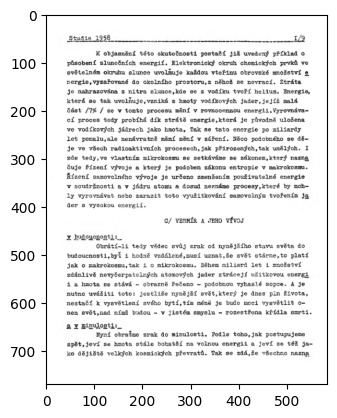

In [11]:
plt.imshow(np_array)

Snadno si zobrazíme např. pouze výřez této stránky.

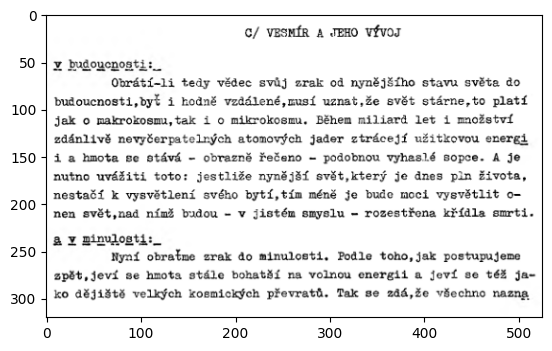

In [12]:
plt.imshow(np_array[410:730, 35:560])

Nyní se vraťme k našemu objektu `p`, který reprezentuje veškerá data spojená s danou stránkou. Velice přímočarým způsobem získáme kompletní textový obsah:

In [13]:
print(p.get_text())

Studie 1958
I
/
9
K objasnění této skutečnosti postačí již uvedený příklad o 
působení slunečních energií. Elektronický okruh chemických prvků ve 
světelném okruhu slunce uvolňuje každou vteřinu obrovské množství £  
nergie,vyzařované do okolního prostoru,z něhož se nevrací. Ztráta 
je nahrazována z nitra slunce,kde se z vodíku tvoří helium. Energie, 
která se tak uvolňuje,vzniká z hmoty vodíkových jader, jejíž malá 
část /l°/o / se v tomto procesu mění v rovnocennou energii.Vyrovnáva- 
cí proces tedy probíhá dík ztrátě energie,která je původně uložena 
ve vodíkových jádrech jako hmota, Tak se tato energie po miliardy 
let pomalu,ale nenávratně mění mění v záření. Něco podobného se dě­
je ve všech radioaktivních procesech,jak přirozených,tak umělých. I 
zde tedy,ve vlastním mikrokosnru se setkáváme se zákonem,který nazna 
čuje řízení vývoje a který je podoben zákonu entropie v makrokosmu. 
Řízení samovolného vývoje je určeno zmenšením použivatelné energie 
v soudržnosti a v jádru atomu

Pokročilejší způsob představuje vyjmout textová data ze stránky po jednotlivých textových blocích, které obsahují i informaci o svém geometrickém umístění uvnitř stránky:

In [14]:
p = doc.load_page(3)
textblocks = p.get_text_blocks() # ("blocks")
textblocks[:15]

[(46.099998474121094,
  91.5589599609375,
  151.80401611328125,
  109.75896453857422,
  'P I U S  XII :\n',
  0,
  0),
 (141.60000610351562,
  119.41600036621094,
  458.4000244140625,
  136.21600341796875,
  'DŮKAZY JSOUCNOSTI BOŽÍ VE SVĚTLE MODERNÍCH \n',
  1,
  0),
 (208.30001831054688,
  140.56602478027344,
  323.5961608886719,
  157.36602783203125,
  'PŘÍRODNÍCH VĚD.\n',
  2,
  0),
 (142.5500030517578,
  161.41600036621094,
  443.0400390625,
  178.21600341796875,
  '/Řeč sv.Otce k papežské vědecké akademií \n',
  3,
  0),
 (223.4500274658203,
  184.2150115966797,
  310.43817138671875,
  201.0150146484375,
  '22.XI.1951*/\n',
  4,
  0),
 (90.69999694824219,
  224.5659637451172,
  540.2086181640625,
  241.365966796875,
  'Toto shromáždění papežské vědecké akademie Nám poskytuje chví\n',
  5,
  0),
 (474.70001220703125,
  240.45994567871094,
  479.20001220703125,
  249.82745361328125,
  'v\n',
  6,
  0),
 (46.79899978637695,
  245.41600036621094,
  547.8989868164062,
  262.21600341796

Geometrie zde vymezuje dva body ohraničující obdelník, v němž se text nachází:

In [15]:
rect = textblocks[2][:4]

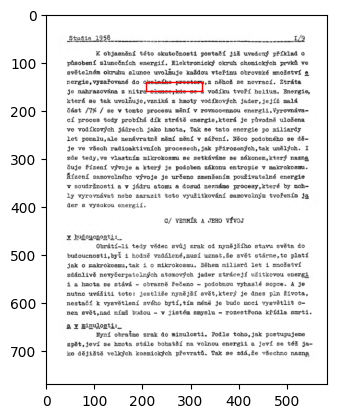

In [16]:
fig, ax = plt.subplots()
ax.imshow(np_array)
patch = patches.Rectangle((rect[0], rect[1]),  # Bottom left corner
                          rect[2] - rect[0],  # Width
                          rect[3] - rect[1],  # Height
                          linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(patch)

Mít povědomí o těchto strukturálních vlastnostech PDF dokumentů je velice důležité, když z těchto dokumentů chceme získat strojově čitelný text pro další textové analýzy. PDF dokumenty jsou například často opatřeny záhlavím či zápatím, kde se objevuje třeba název periodika (jako je tomu zde), jméno autora, jméno příspěvku či číslo stránky. Vyextrahujeme-li ze všech stránek v daném dokumentu syrový text pomocí p.get_text(), budeme v našem textu mít i řetězce znaků z těchto textových bloků, což není žádoucí. Buď se tomu pokusíme předejít již při samotné extrakci, kdy můžeme využít geometrické polohy jednotlivých text bloků,  nebo se těchto dat pokusíme zbavit během následného čištění, např. pomocí *regulérních výrazů* (viz příslušná kapitola). Který případ je vhodnější závisí případ od případu a vyžaduje testování. Zde se budeme držet druhého případu.

In [17]:
text = ""
for p in doc:
    text += p.get_text()

In [18]:
text[5000:6000]

'námky světa.\nZ těchto "způsobů bytí" světa kolem nás,které s větším nebo \nmenším pochopením,ale vždy se stejnou zřejmostí zdůrazňují filosofo-\nl/L\nStudie 1958\nvé i všeobecná inteligence,moderní věda nad veškeré očekávání podi\xad\nvuhodné prozkoumala,potvrdila a prohloubila zvláště dva: 1/ proměn\xad\nlivost věcí,včetně jejich zrodu a zániku; 2/ řád účelnosti,který v£ \nzaruJe ze všech stran. Věda takto velmi významně prospěla dvěma fi\xad\nlosofickým důkazům,které se zakládají na těchto skutečnostech a kte, \nré tvoří první a pátou cestu. Zvláště první cestě fysika poskytla \nnevyčerpatelný zdroj zkušeností tím,že odhalila proměnlivost v hlu\xad\nbinách přírody,kde dříve nikdo nemohl tušit její přítomnost a roz\xad\nsáhle dodala mnoho dokazatelných skutečností,které jsou velikou po \nmocí pro filosofické úvahy.Pravíme pomocí; zdá se Nám totiž,že říze \nzení těchto proměn, i když je moderní fysika z jistila, převyšuje hod\xad\nnotu pouhého potvrzení dosahuje skoro stavby a stupně

Zkusme se zbavit všech záhlaví pomocí regexu:

In [19]:
pattern = "(_+)?(\n?Studie[\s_]+\d{4}\n?)(\W*\w{0,3}\s*/\s*\d\n?)?"
re.findall(pattern, text)[:10]

[('', '\nStudie 1958\n', 'I/3\n'),
 ('', '\nStudie 1958\n', ''),
 ('', '\nStudie 1958\n', ''),
 ('', '\nStudie 1958\n', ''),
 ('', '\nStudie 1958\n', ''),
 ('', 'Studie 1958\n', ''),
 ('', 'Studie 1958\n', 'I\n/\n9\n'),
 ('', '\nStudie 1958\n', 'I/1'),
 ('', '\nStudie 1958\n', 'I /1'),
 ('',
  '\nStudie 1958',
  '                                                     I/1')]

In [20]:
text = re.sub(pattern, "\n", text)
text[3000:5000]

' seskupila \nve filosofických důkazech,vytříbených během st letí velikými mysli-\nteli. Vy znáte toto svědectví jako "pět cest",které andělský učitel \nsv.Tomáš podává jako rychlou a bezpečnou cestu mysli k Bohu. Pravi\xad\nli jsme filosofické důkazy; nejsou však proto aprioristické,jak to \no nich tvrdí úzkoprsý a nedůsledný positivisraus. Tyto důkazy jsou \nstavěny na konkrétních skutečnostech,potvrzených smysly i vědou, i \nkdyž jim důkazné síly dodává schopnost přirozeného rosnímu.\nTakto se filosofie i vědy rozvíjejí podle podobných a slu\xad\nčitelných method i činnosti,používajíce v různé míře pokusných a \nrozumových prvků a snažíce se v souladné jednotě o odhalení pravdy.\nUž prvotní zkušenost starých lidí mohla poskytnout rozumu \ndostatečné důkazy jsoucnosti Boží; ale rozšíření a prohloubení Sa\xad\nmého pole zkušenosti nyní ještě více ozařuje a zdůrazňuje stopu vě_č \nnosti ve viditelném světě. Zdá se Nám proto vhodné znovu prozkouma- \nti na základě nových vědeckých objev

Na text aplikujeme ještě několik čistících funkcí.

In [21]:
text = re.sub("\xad\n", "", text)
text = text.replace("- \n", "")
text = re.sub("\s\s+", " ", text.replace("\n", " "))
text[10000:11000]

'í také ionisace atomu a přeměna energie v synthesi a analysi chemických sestav. Mohlo se však předpokládat,že tyto chemicko-fyeioké změny poskytují ještě útulek stálosti,nebot nedosahují samého atomového jádra,sídla to hmoty a kladného elektrického náboje, jimiž je určeno místo chemického atomu v přírodní soustavě prvků a kde jak se zdálo - nalézáme vzor naprosté stálosti a nemění i vosti. a X ládru:_ Ale již na začátku nového století vedlo pozorování radioaktivních procesů,které konec konců mají vztah k mimovolnému tříštění jádra,k vyloučení takového vzoru. Ačkoliv tedy byla zjištěna nestálost i v nejhlubším koutku poznané přírody,přece zůstávala jedna zarážející skutečnost: zdálo se totiž,že atom je nedotknutelný alespoň lidskými silami,protože na začátku selhaly všechny pokusy o zrychlení nebo zastavení přirozeného radioaktivního rozkladu I/7 nebo i o rozštěpení neaktivních jáder. I*rvní velmi skromné rozštěpení jádra /dusíku/ se^godařilo sotva před třicíti lety a teprve před někol

Výsledek zdaleka není perfektní. V textu stále vidíme řadu problémů. Některé souvisejí s formátováním, jiné jsou dědictvím OCR analýzy. Pro naše aktuální potřeby však text v této podobě postačuje. 

Zkusme se však podívat na jiný text z téhož periodika:

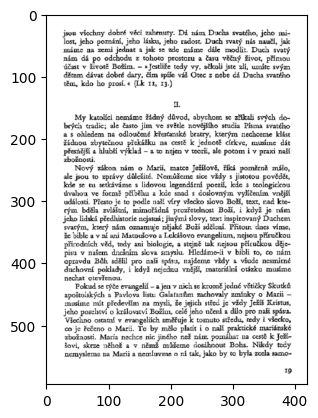

In [22]:
url = "https://scriptum.cz/soubory/scriptum/studie/studie_1978_055_ocr.pdf"
pdf_object = io.BytesIO(requests.get(url).content)
doc = fitz.open("pdf", pdf_object.read())
p = doc.load_page(20) # vybereme stránku
pix = p.get_pixmap()
np_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)


plt.imshow(np_array)

Vidíme, že text je nyní formátovaný odlišně. Například chybí původní záhlaví. Namísto toho vidíme v zápatí čísla stránek. V extrahovaném textu se pokusíme nyní zbavit i těch.

In [23]:
p.get_text()

'jsou všechny dobré věci zahrnuty. Dá nám Ducha svatého, jeho mi-\nlost, jeho poznání, jeho lásku, jeho radost. Duch svatý nás naučí, jak \nmáme na zemi jednat a jak se zde máme dále modlit. Duch svatý \nnám dá po odchodu z tohoto prostoru a času věcný život, přímou \núčast v životě Božím. - »Jestliže tedy vy, ačkoli jste zlí, umíte svým \ndětem dávat dobré dary, čím spíše váš Otec z nebe dá Ducha svatého \ntěm, kdo ho prosí. « (Lk n , 13.) \nII. \nMy katolíci nemáme žádný důvod, abychom se zříkali svých do-\nbrých tradic; ale často jim ve světle novějšího studia Písma svatého \na s ohledem na odloučené křesťanské bratry, kterým nechceme klást \nžádnou zbytečnou překážku na cestě k jednotě církve, musíme dát \npřesnější a hlubší výklad - a to nejen v teorii, ale potom i v praxi naší \nzbožnosti. \nNový zákon, nám o Marii, matce Ježíšově., říká poměrně málo, \nale jsou to zprávy důležité. Nemůžeme sice vždy s jistotou povědět, \nkde se tu setkáváme s lidovou legendární poezií, kde s teo

In [24]:
re.sub("\n\s?\d{1,3}\s?\n", "\n", p.get_text())

'jsou všechny dobré věci zahrnuty. Dá nám Ducha svatého, jeho mi-\nlost, jeho poznání, jeho lásku, jeho radost. Duch svatý nás naučí, jak \nmáme na zemi jednat a jak se zde máme dále modlit. Duch svatý \nnám dá po odchodu z tohoto prostoru a času věcný život, přímou \núčast v životě Božím. - »Jestliže tedy vy, ačkoli jste zlí, umíte svým \ndětem dávat dobré dary, čím spíše váš Otec z nebe dá Ducha svatého \ntěm, kdo ho prosí. « (Lk n , 13.) \nII. \nMy katolíci nemáme žádný důvod, abychom se zříkali svých do-\nbrých tradic; ale často jim ve světle novějšího studia Písma svatého \na s ohledem na odloučené křesťanské bratry, kterým nechceme klást \nžádnou zbytečnou překážku na cestě k jednotě církve, musíme dát \npřesnější a hlubší výklad - a to nejen v teorii, ale potom i v praxi naší \nzbožnosti. \nNový zákon, nám o Marii, matce Ježíšově., říká poměrně málo, \nale jsou to zprávy důležité. Nemůžeme sice vždy s jistotou povědět, \nkde se tu setkáváme s lidovou legendární poezií, kde s teo

In [25]:
text = ""
for p in doc:
    text += p.get_text()

In [26]:
pattern = "(_+)?(\n?Studie[\s_]+\d{4}\n?)(\W*\w{0,3}\s*/\s*\d\n?)?"
text = re.sub(pattern, "\n", text)
text = re.sub("\n\s?\d{1,3}\s?\n", "\n", text)
text = re.sub("\xad\n", "", text)
text = text.replace("- \n", "")
text = re.sub("\s\s+", " ", text.replace("\n", " "))
text[10000:12000]

' mezi oběma funkcemi Ducha svatého. Jaký je pomer mezi Duchem přebývajícím a Duchem přichá- zejícím? - čili, jak se k sobě mají charismata a ovoce Ducha, tj. mravní a duchovní výsledky křesťanského úsilí o bohulibý život? Je to vlastně otázka po vnitřním napětí v samé bytosti Ducha svatého, jež jsme si zpříkladnili rozlišováním jeho dvou funkcí, neboť jej známe jen z jeho působení. Na tuto otázku odpovídají ze zkušenosti tí z křesťanů, kteří funkci charismat již dlouho znají, členové letničních linutí. Ti vědí, že charisniatik, který zároveň nejde cestou křesťanského mravního i duchovního snažení, vedoucí k posvěcení (dle pietistického schématu) žíi k duchovní iluminaci (dle mystiků) - není genuirmím křesťanem podle evangelia. O tom svědci H. K. Neerskov, člen letničního sboru v Kodani: » Duck sv. v nich (ckarismaticích) sice přebývá, ale oni jej, žel, ignoruji Nevědí, jaké požehnání .přináší život v Duchu svatém, a proto nad nimi Duch nemá moci. Jsou více zaujati silou Ducha ... užív

Výsledný text má daleko od dokonalosti. My se s ním však nyní spokojíme a postoupíme dále. Pomocí funkcí použitých výše vyexportujeme text ze všech čísel daného periodika. Použijeme k tomu webovou stránku rozcestníku, na kterém jsou všechny soubory dostupné v uspořádaném seznamu:

https://scriptum.cz/soubory/scriptum/studie/

Použijeme obdobný postup, jaký jsme použili v kapitole o webscrapingu. Nejprve si vyextrahujeme seznam jmen všech relevantních souborů (zajímají nás pouze souboru, které končí "ocr.pdf" - i zde se nám hodí regex).


In [52]:
len(text)

215339

In [62]:
chunks = re.findall(r'.{0,50000}\.\s', text, re.DOTALL)
chunks_end = sum([len(chunk) for chunk in chunks])
chunks.append(text[chunks_end:])
docs = [nlp(chunk) for chunk in chunks]

In [65]:
[len(chunk) for chunk in chunks]

[19938, 195401]

In [ ]:
combined_text = " ".join(doc.text for doc in docs)
combined_doc = nlp(combined_text)

In [ ]:
combined_doc = stanza.Document(sentences=[sentence for doc in docs for sentence in doc.sentences])

In [ ]:
combined_doc

In [27]:
resp = requests.get("https://scriptum.cz/soubory/scriptum/studie/")
soup = BeautifulSoup(resp.content)
hrefs = [a.get('href') for a in soup.find_all("a")]
hrefs = [href for href in hrefs if re.search("ocr\.pdf$", href)]
hrefs = [href for href in hrefs if not ("rejstrik" in href or "obsah" in href)]
hrefs[:20]

['studie_1958_001_ocr.pdf',
 'studie_1958_002_ocr.pdf',
 'studie_1958_003_ocr.pdf',
 'studie_1959_004_ocr.pdf',
 'studie_1960_006_ocr.pdf',
 'studie_1961_005_ocr.pdf',
 'studie_1961_007_ocr.pdf',
 'studie_1962_008_ocr.pdf',
 'studie_1963_009_ocr.pdf',
 'studie_1965_010_ocr.pdf',
 'studie_1965_011_ocr.pdf',
 'studie_1966_012_ocr.pdf',
 'studie_1967_013_ocr.pdf',
 'studie_1968_014_ocr.pdf',
 'studie_1968_015_ocr.pdf',
 'studie_1968_016_ocr.pdf',
 'studie_1969_017_ocr.pdf',
 'studie_1969_018-019_ocr.pdf',
 'studie_1969_020_ocr.pdf',
 'studie_1970_021_ocr.pdf']

In [28]:
len(hrefs)

105

Nyní si vytvoříme funkci, do které vnoříme všechny extrakční, transformační a čistící procedury, které jsme prošli výše.  

In [39]:
base_url = "https://scriptum.cz/soubory/scriptum/studie/"
def get_cleaned_text(filename):
    try:
        url = base_url + filename
        pdf_object = io.BytesIO(requests.get(url).content)
        doc = fitz.open("pdf", pdf_object.read())
        text = ""
        for p in doc:
            text += p.get_text()
        pattern = "(_+)?(\n?Studie[\s_]+\d{4}\n?)(\W*\w{0,3}\s*/\s*\d\n?)?"
        text = re.sub(pattern, "\n", text)
        text = re.sub("\n\s?\d{1,3}\s?\n", "\n", text)
        text = re.sub("\xad\n", "", text)
        text = re.sub("\s\s+", " ", text.replace("\n", " "))
        text = text.replace("- \n", "")
        year = int(re.search("\d{4}", filename).group())
        return filename, year, text
    except:
        pass

A následně tuto funkci aplikujeme jeden po druhém na všechny dostupné soubory pomocí cyklu FOR. Máme před sebou více než 100 jmen souborů, tj. vzneseme více než 100 HTTP dotazů. Tudíž provedení kódu zabere nějaký čas.

In [40]:
%%time
scriptum_data = []
for filename in hrefs:
    filename, year, text = get_cleaned_text(filename)
    scriptum_data.append({"filename" : filename, "year" : year, "text" : text})

CPU times: user 26.6 s, sys: 7.76 s, total: 34.3 s
Wall time: 1min 26s


Vyextrahovaná data si převedeme do objektu typu `pandas.DataFrame` 

In [41]:
scriptum_df = pd.DataFrame(scriptum_data)
scriptum_df.head(10)

,filename,year,text
0,studie_1958_001_ocr.pdf,1958,"""Pravda vás osvobodí"" (Jn 8, 32) KŘESŤANSKÁ AK..."
1,studie_1958_002_ocr.pdf,1958,"""Pravda vás osvobodí (Jn 8, 32) KŘESŤANSKÁ AKA..."
2,studie_1958_003_ocr.pdf,1958,""" Pravda vás osvobodí"" <JN 8, 32) KŘESŤANSKÁ A..."
3,studie_1959_004_ocr.pdf,1959,""" Pravda vás osvobodí "" (Jn a, 32) v ,L K Ř E ..."
4,studie_1960_006_ocr.pdf,1960,"WWi: WĚĚKBKm ""Pravda vás osvobodí (Jn 8,32) K ..."
5,studie_1961_005_ocr.pdf,1961,"""Pravda vás osvobodí (In IS.K) K Ř E S Ť A N S..."
6,studie_1961_007_ocr.pdf,1961,"""Pravda vás osvobodí (Jn 8,32) K Ř E S Ť A N S..."
7,studie_1962_008_ocr.pdf,1962,"""l'ravda vas osvobodí ÍJ-i H.32) K Ř E S Ť A N..."
8,studie_1963_009_ocr.pdf,1963,""" Pravda vás osvobodí "" (Jn 8,32) KŘESŤANSKÁ A..."
9,studie_1965_010_ocr.pdf,1965,"41 Pravda vás osvobodí "" <Jn 8,32) KŘESŤANSKÁ ..."


Spočteme počet znaků v každém z námi vyextrahovaných textů a vytvoříme nový sloupec "n_chars", kam tuto hodnotu uložíme.

In [42]:
scriptum_df["n_chars"] = scriptum_df["text"].str.len()
scriptum_df.head(5)

,filename,year,text,n_chars
0,studie_1958_001_ocr.pdf,1958,"""Pravda vás osvobodí"" (Jn 8, 32) KŘESŤANSKÁ AK...",215339
1,studie_1958_002_ocr.pdf,1958,"""Pravda vás osvobodí (Jn 8, 32) KŘESŤANSKÁ AKA...",199361
2,studie_1958_003_ocr.pdf,1958,""" Pravda vás osvobodí"" <JN 8, 32) KŘESŤANSKÁ A...",200051
3,studie_1959_004_ocr.pdf,1959,""" Pravda vás osvobodí "" (Jn a, 32) v ,L K Ř E ...",165962
4,studie_1960_006_ocr.pdf,1960,"WWi: WĚĚKBKm ""Pravda vás osvobodí (Jn 8,32) K ...",172584


Díky tomu můžeme sečíst celkový počet znaků všech textů z daného periodika.

In [43]:
scriptum_df["n_chars"].sum()

32524219

Tímto se nám tedy dostal do rukou další nemalý dataset zajímavých kulturních dat. Pokud pracujeme s repozitoří "pribehy-dat" jako celkem, dataset si uložíme do podsložky data:  

In [44]:
scriptum_df.to_json("../data/scriptum_df.json")

# Rozšiřující analýza: Zpracování textových dat

Nyní trochu přeskočíme k tématu, kterým se budeme zabývat samostatně v jedné z následujících kapitol: kvantitativní textová analýza. Následující sérii kroků proto si proto v tuto chvíli nebudeme podrobně vysvětlovat, zaměříme se až na výsledná data.

Budeme k nim potřebovat knihovnu stanza, kterou je třeba si doinstalovat pomocí příkazu `!pip install stanza` a model pro předzpracování textových dat v češtině.

In [4]:
scriptum_df = pd.read_json("../data/scriptum_df.json")

In [14]:
%%capture
# !pip install stanza
import stanza
stanza.download("cs")
nlp = stanza.Pipeline("cs")
import pickle
import os

Pro testovací účely si vybereme jeden text z jednoho čísla:

In [6]:
text = scriptum_df["text"].tolist()[0]
text[2000:3000]

'o nevýslovném souladu nejvýš moudré- ho Boha. Vskutku,čím více pravá věda - v opak toho,co se tvrdilo v mi- nulosti - postupuje,tím více odhaluje Boha,jako by on sám čekal za každou branou,kterou věda otevře. Ba musíme říci,že toto postupné odhalování Boha,dosahované vzrůstem vědy,nejen obohacuje vědce,kdy- koli uvažuje - a jak by nemohl nečiniti tak? - jako filosof, nýbrž že z něho čerpají užitek i všichni ti,kteří mají podíl na nových ná lezech nebo je činí předmětem svých úvah.Zvláště z toho mají užitek praví filosofové,neboí jsou vědeckými objevy pobádáni k rozumovým úvahám,a proto z onoho postupného odhalování Boha čerpají větší jis totu pro svoje závěry,více světla v nejasných otázkách a přesvědči- vější důkazy k tomu,aby mohli dávat stále uspokojivější odpověě na potíže a námitky. Příroda a základy důkazů jsoucnosti Boží. Jsa takto pobádán aveden,zaujímá lidský rozum stanovisko k ono mu svědectví o jsoucnosti Boží,které křesťanská moudrost seskupila ve filosofických důkazech,vy

Na celý dokument aplikujeme jazykový model pro předzpracování, který text automaticky:
* rozdělí do vět
* věty do slov
* jednotlivým slovům přiřadí *lemmata*, tj. převede je do tvarů, jak je najdeme ve slovníku (např. "je" -> "být").
* přiřadí jim "part-of-speech" (POS) tagy (např. "NOUN", "VERB" apod. "PUNCT" apod.)

In [7]:
len(text)

215339

In [7]:
%%time
doc = nlp(text)

CPU times: user 47.3 s, sys: 8.68 s, total: 56 s
Wall time: 39.6 s


Vytvořili jsme nový `stanza` objekt `doc`, který obsahuje podrobně jazykově anotovanou reprezentaci celého textu. Z této reprezentace si nyní vyjmeme pouze lemmata vybraných slovních druhů: 

In [8]:
lemmatized_sents = []
for sent in doc.sentences:
    lemmatized_sents.append([t.lemma for t in sent.words if t.upos in ["PROPN", "NOUN", "VERB", "ADJ"]])
print(lemmatized_sents[100:110])

[['slavný', 'znalec', 'atomový', 'fysika', 'spolupráce', 'stronom', 'astrofysika', 'snažit', 'osvětlit', 'těžký', 'mimořád', 'zajímavý', 'problém', 'D', 'počátek', 'Č'], ['Veda', 'znát', 'způsob', 'uvést', 'číslo', 'mít', 'vyjádřit', 'veličina', 'označení', 'vznik', 'vesmír', 't', 'j', 'počátek', 'čas'], ['uvést', 'krátco', 'způsob', 'závislý', 'splývat', 'oddajlování', '_S£irálov^ch_', 'viněný', 'bo', 'mléčný', 'dráha'], ['zkoumání', 'četný', 'spirálový', 'mlhovina', 'konat', 'Edwin', 'S', 'Hubble', 'Wilson', 'přinést', 'významný', 'výsledek', 'mírněný', 'určitý', 'výhrada'], ['vzdálený', 'soustava', 'mléčný', 'dráha', 'oddalovat', 'velký', 'rychlost', 'vzdálenost', 'spirálový', 'mlhovina', 'léta', 'zdvojnásobit'], ['uvažovat', 'čas', 'proces', 'Expanding', 'U', 'vyplývat', 'léta', 'začít', 'kosmický', 'směna', 'hmota', 'spirálový', 'mlhovina', 'stěsnaný', 'malý', 'prostor'], ['rok', 'stáří', 'zemský', '^kůrx'], ['vypočítání', 'stáří', 'původní', 'radio', 'aktivní', 'hmota', 'brát', '

Ani v tomto případě nejsou výsledky ani zdaleka perfektní. Vše se odvíjí zejména z kvality vstupních dat. Vidíme např., že model si nedokáže poradit se slovy, které jsou ve stupních datech zachycena v rozdělené podobě apod. I přesto nyní postoupíme dále a aplikujeme danou proceduru na texty všech čísel. 

Opět si pro tento účel nadefinujeme speciální funkci.

In [15]:
processed = []
!mkdir ../data/large_files
!mkdir ../data/large_files/lemsents
def get_lemmatized_sentences(filename, text, n_chars):
    if filename not in ["studie_1990_132_ocr.pdf"]:
        if filename + ".pickle" not in os.listdir("../data/large_files/lemsents/"):
            chunks = re.findall(r'.{0,50000}\.\s', text, re.DOTALL)
            chunks_end = sum([len(chunk) for chunk in chunks])
            chunks.append(text[chunks_end:])
            docs = [nlp(chunk) for chunk in chunks]
            lemmatized_sents = []
            for doc in docs:
                for sent in doc.sentences:
                    lemmatized_sents.append([t.lemma for t in sent.words if t.upos in ["PROPN", "NOUN", "VERB", "ADJ"]])
            processed.append(filename)
            pathfn = "../data/large_files/lemsents/" + filename + ".pickle"
            with open(pathfn, 'wb') as f:
                pickle.dump(lemmatized_sents, f)
            print(filename, n_chars, len(processed))
        else:
            pathfn = "../data/large_files/lemsents/" + filename + ".pickle"
            with open(pathfn, 'rb') as f:
                lemmatized_sents = pickle.load(f)
    else:
        lemmatized_sents = None
    return lemmatized_sents

Aplikace této funkce na všechny dokumenty v seznamu však zabere značný čas. Abychom se vyhnuli čekání, načteme si proto data, v kterých jsem již tuto proceduru aplikoval dříve (jak jsem to provedl je vidět v zakomentovaných příkazech v buňce níže.

In [16]:
%%time
scriptum_df["lemmatized_sents"] = scriptum_df.apply(lambda row: get_lemmatized_sentences(row["filename"], row["text"], row["n_chars"]), axis=1)
# scriptum_df.to_json("../data/scriptum_lemmatized_df.json")
# scriptum_df = pd.read_json("https://raw.githubusercontent.com/CCS-ZCU/pribehy-dat/master/data/scriptum_lemmatized_df.json")

studie_1958_001_ocr.pdf 215339 1
studie_1958_002_ocr.pdf 199361 2
studie_1958_003_ocr.pdf 200051 3
studie_1959_004_ocr.pdf 165962 4
studie_1960_006_ocr.pdf 172584 5
studie_1961_005_ocr.pdf 252048 6
studie_1961_007_ocr.pdf 125453 7
studie_1962_008_ocr.pdf 245232 8
studie_1963_009_ocr.pdf 233809 9
studie_1965_010_ocr.pdf 148947 10
studie_1965_011_ocr.pdf 295626 11
studie_1966_012_ocr.pdf 308120 12
studie_1967_013_ocr.pdf 174017 13
studie_1968_014_ocr.pdf 122658 14
studie_1968_015_ocr.pdf 165295 15
studie_1968_016_ocr.pdf 197975 16
studie_1969_017_ocr.pdf 308538 17
studie_1969_018-019_ocr.pdf 460742 18
studie_1969_020_ocr.pdf 244231 19
studie_1970_021_ocr.pdf 305314 20
studie_1970_022_ocr.pdf 378349 21
studie_1970_023-024_ocr.pdf 341048 22
studie_1971_025-026-027_ocr.pdf 520773 23
studie_1971_028_ocr.pdf 266916 24
studie_1972_029_ocr.pdf 362689 25
studie_1972_030_ocr.pdf 461970 26
studie_1972_031-032_ocr.pdf 167122 27
studie_1973_033_ocr.pdf 807640 28
studie_1973_034-035_ocr.pdf 382001 29

In [17]:
scriptum_df.head(10)

,filename,year,text,n_chars,lemmatized_sents
0,studie_1958_001_ocr.pdf,1958,"""Pravda vás osvobodí"" (Jn 8, 32) KŘESŤANSKÁ AK...",215339,"[[pravda, osvobodit, Jn, křesšanský, akademie,..."
1,studie_1958_002_ocr.pdf,1958,"""Pravda vás osvobodí (Jn 8, 32) KŘESŤANSKÁ AKA...",199361,"[[pravda, osvobodit, Jn, křesšanský, akademie,..."
2,studie_1958_003_ocr.pdf,1958,""" Pravda vás osvobodí"" <JN 8, 32) KŘESŤANSKÁ A...",200051,"[[pravda, osvobodit, <, JN, křesšanský, akadem..."
3,studie_1959_004_ocr.pdf,1959,""" Pravda vás osvobodí "" (Jn a, 32) v ,L K Ř E ...",165962,"[[pravda, osvobodit, Jn, v, L, K, Ř, E, S, Ť, ..."
4,studie_1960_006_ocr.pdf,1960,"WWi: WĚĚKBKm ""Pravda vás osvobodí (Jn 8,32) K ...",172584,"[[WWi, Wěěkbě, pravda, osvobodit, Jn, K, Ř, E,..."
5,studie_1961_005_ocr.pdf,1961,"""Pravda vás osvobodí (In IS.K) K Ř E S Ť A N S...",252048,"[[pravda, osvobodit, IS, K, K, Ř, E, S, Ť, A, ..."
6,studie_1961_007_ocr.pdf,1961,"""Pravda vás osvobodí (Jn 8,32) K Ř E S Ť A N S...",125453,"[[pravda, osvobodit, Jn, K, Ř, E, S, Ť, A, N, ..."
7,studie_1962_008_ocr.pdf,1962,"""l'ravda vas osvobodí ÍJ-i H.32) K Ř E S Ť A N...",245232,"[[l', ravda, vas, osvobodit, ÍJ, H, K, Ř, E, S..."
8,studie_1963_009_ocr.pdf,1963,""" Pravda vás osvobodí "" (Jn 8,32) KŘESŤANSKÁ A...",233809,"[[pravda, osvobodit, Jn, křesšanský, akademie,..."
9,studie_1965_010_ocr.pdf,1965,"41 Pravda vás osvobodí "" <Jn 8,32) KŘESŤANSKÁ ...",148947,"[[pravda, osvobodit, <, Jn, křesšanský, akadem..."


In [18]:
scriptum_df.to_json("../data/large_files/scriptum_df_lemmata.json")

Nyní si nadefinujeme funkci, pomocí které budeme moci vyextrahovat veškeré věty obsahující konkrétní slova.

In [33]:
def extract_target_sents(lemmatized_sents, targets):
    try:
        return [sent for sent in lemmatized_sents if any(target in sent for target in targets)]
    except:
        return []

In [34]:
my_targets = ["kultura"]
scriptum_df["target_sents"] = scriptum_df["lemmatized_sents"].apply(extract_target_sents, args=(my_targets,))

In [35]:
scriptum_df["target_sents"].apply(lambda x: len(x) if x != None else 0).sum()

2641

In [36]:
scriptum_df["target_sents"]

0                                                     []
1      [[propast, dělit, svět, rostný, rostlina, zvíř...
2      [[tatarský, vpád, všeobecný, kultura, upadnout...
3      [[žád, néma, exil, kvést, kultura, umění, cena...
4      [[kládat, škola, středisko, kultura, uchránit,...
                             ...                        
100    [[směr, pověření, hovořit, námý, stek, ministr...
101    [[český, bohoslovec, navazo, vale, český, náro...
102    [[T, D, E, OTCB, sbírka, kultura, Mestapystka,...
103    [[poslední, řada, udělat, přežití, český, slov...
104                                                   []
Name: target_sents, Length: 105, dtype: object

Jaká slova se v těchto větách objevují nejčastěji?

In [40]:
[t for sent in [t for sent in column_sents for t in sent] for t in sent] # if isinstance(sent, list)]

['propast',
 'dělit',
 'svět',
 'rostný',
 'rostlina',
 'zvíře',
 'rušivý',
 'překážka',
 'zabraňovat',
 'moci',
 'klidný',
 'svědomí',
 'prohlásit',
 'člo',
 'věk',
 'kultura',
 'intelektuální',
 'život',
 'lým',
 'článeček',
 'tok',
 'věčný',
 'vývoj',
 'hmota',
 'směr',
 'mít',
 'Evropa',
 'určitouvýhod',
 'kultura',
 'be^',
 'secundum',
 'křestanský',
 'zachovat',
 'jedný',
 'kres',
 'tanský',
 'hodnota',
 'stavba',
 '.původ',
 'lidský',
 'dějiny',
 'život',
 'sga',
 'lečr',
 'oseta',
 'jednotlivec',
 'vývoj',
 'kultura',
 'obsažený',
 'myl',
 'hřích',
 'přispívat',
 'pásový',
 'výroba',
 'bytový',
 'kultura',
 'početný',
 'byt',
 'místnost',
 'výchova',
 'tisk',
 'radio',
 'kino',
 'volný',
 'chvíle',
 'zábava',
 'využívaný',
 'ovlivnovaný',
 'obchod',
 'jednota',
 'lidstvo',
 'bůh',
 'rušit',
 'zeměpisný',
 'vzdálenost',
 'různost',
 'civilisace',
 'kultura',
 'hospodářství',
 'tatarský',
 'vpád',
 'všeobecný',
 'kultura',
 'upadnout',
 'styk',
 'západ',
 'přestat',
 'Hus',
 'ka'

In [44]:
column_sents = scriptum_df["target_sents"].tolist()
target_sents_counts = nltk.FreqDist([t for sent in [t for sent in column_sents for t in sent] for t in sent]) #
target_sents_counts.most_common(20)

[('kultura', 2877),
 ('český', 440),
 ('mít', 256),
 ('člověk', 238),
 ('národ', 224),
 ('život', 220),
 ('moci', 215),
 ('lidský', 193),
 ('stát', 190),
 ('křesťanský', 186),
 ('svět', 181),
 ('evropský', 181),
 ('nový', 179),
 ('dějiny', 167),
 ('kulturní', 162),
 ('ministerstvo', 151),
 ('rok', 146),
 ('strana', 141),
 ('církev', 141),
 ('víra', 140)]